# Fixation, Saccade and Blink Analysis Cyprus Data

This code was developed and written by Jasmin L. Walter

In [ ]:
%reset

## Import

In [1]:
import copy  # copy big/deep objects by value
import csv
import datetime  # datetime operations
import itertools  # operate with iterators
import json  # read/write from/into json format
import math
import os  # OS operations (read/write files/folders)
import sys
import time
import warnings  # hide warnings
from collections import Counter
from itertools import groupby
import matplotlib

# process parallelization
from multiprocessing import Manager, Pool, RawArray, cpu_count
from os.path import exists

import matplotlib.pyplot as plt  # mother of plots focr Python

# import mlxtend
import numpy as np  # array/matrix operations (e.g. linear algebra)
import pandas as pd  # operate with dataframes
# import pyxdf  # read XDF files (LSL streams recordings)

import scipy.stats
import seaborn as sns  # matplotlib plotting nice with shortcuts
from IPython.display import Markdown, display  # print nicely
from ipywidgets import IntProgress
#from matplotlib.pyplot import cm
from scipy.signal import savgol_coeffs
from tqdm.notebook import tqdm, trange  # mother of progressbars
from scipy.stats import ks_2samp
from multiprocessing import Pool, cpu_count

import scipy.signal
import matplotlib.ticker as ticker

In [2]:
# warnings.simplefilter(action="ignore", category=FutureWarning)

# raw and processed data paths
# PATH_RAW = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/27.07.23/data"
# PATH_PROC = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/EEG_Data_Skripte_Debbie/Events"
# PATH_FOREYE = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/EEG_Data_Skripte_Debbie/ET_Output_MAD-sacc"
# PATH_TRG = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/EEG_Data_Skripte_Debbie/TriggerFiles_fEEG"


# specify decimals format on pandas tables
# pd.options.display.float_format = "{:.5f}".format

# inline static plotting (default)
%matplotlib inline
# interactive plotting
# %matplotlib widget

# progress bar customized format
B_FORMAT = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar} 
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} ⚙️{rate_fmt}{postfix}"""


CORES = cpu_count()  # number of cpu threads for multiprocessing
print(f"Total CPU threads: {CORES}")


def pbar_fork_hack():
    """
    Hack to enforce progress bars to be displayed by fork processes on
    IPython Apps like Jupyter Notebooks.

    Avoids [IPKernelApp] WARNING | WARNING: attempted to send message from fork

    Important: pass this function as argument for the initializer parameter
    while initializing a multiprocessing pool to make it work. E.g.:

    pool = Pool(processes=N_CORES, initializer=pbar_fork_hack)

    Source:
     - https://github.com/ipython/ipython/issues/11049#issue-306086846
     - https://github.com/tqdm/tqdm/issues/485#issuecomment-473338308
    """
    print(" ", end="", flush=True)

Total CPU threads: 8


In [3]:

savepath = "E:/Cyprus_project_overview/data/analysis/exploration/eyeTracking/fixation_analysis"

# datapath = "D:/Cyprus_project_overview/store_cyprus_project/eyeTrackingData"
datapath = "E:/Cyprus_project_overview/my_data_backup/eye tracking data_backup"



# Getting the Folder without hidden files in ascending order 
data_folders = sorted([f for f in os.listdir(datapath) if not f.startswith('TestS')], key=str.lower)
# PROCESSED_DATA_FOLDER = sorted([f for f in os.listdir(PROCESSED_DATA_PATH) if not f.startswith('.')], key=str.lower)

# savepath = r'F:\WestbrookProject\SpaRe_Data\pre-processing_2023\step1_preparation\'
# os.chdir(r'F:\WestbrookProject\SpaRe_Data\pre-processed_csv\')

In [4]:
# data_folders = [data_folders[0]]  # Take only the first element

print(data_folders)


['Expl_1_ET_1_2023-09-05_11-56-16_ET', 'Expl_1_ET_2_2023-09-05_12-34-24_ET', 'Expl_1_ET_3_2023-09-05_13-10-01_ET', 'Expl_2_ET_1_2023-09-06_10-36-37_ET', 'Expl_2_ET_2_2023-09-06_11-08-36_ET', 'Expl_2_ET_3_2023-09-06_11-39-21_ET', 'Expl_3_ET_1_2023-09-06_13-24-43_ET', 'Expl_3_ET_2_2023-09-06_13-57-57_ET', 'Expl_3_ET_3_2023-09-06_14-28-39_ET', 'Expl_4_ET_1_2023-09-06_18-31-33_ET', 'Expl_4_ET_2_2023-09-06_18-57-24_ET', 'Expl_5_ET_1_2023-09-07_18-17-19_ET', 'Expl_5_ET_2_2023-09-07_18-48-26_ET']


In [5]:
# slicing info
slicingpath = "E:\Cyprus_project_overview\data\slicingLists"

slicingList = pd.read_csv(os.path.join(slicingpath, "mainSlicingList.csv"))
slicingList.head()

,file,session,ET,Paula_start,Paula_start_ns,Paula_end,Paula_end_ns,GPS_sync_start,GPS_sync_start_ns,GPS_sync_end,GPS_sync_end_ns,et_start,et_start_ns,et_end,et_end_ns,experimentStart_worldCFrame,experimentEnd_worldCFrame,experimentStart_worldCFrame_ns,experimentEnd_worldCFrame_ns
0,Expl_1_ET_1_2023-09-05_11-56-16_ET,1,1,13670,1693904632544755555,32920,1693905274388766666,13670,1693904632544755555,32923,1693905274488733333,96373.0,1693904660577857803,217513.0,1693905267619776803,14509.0,32717.0,1693904660521111111,1693905267621355555
1,Expl_1_ET_2_2023-09-05_12-34-24_ET,1,2,9880,1693906794272600000,28805,1693907425280677777,9893,1693906794704611111,28810,1693907425444700000,71073.0,1693906821736889301,190910.0,1693907422101971301,10700.0,28710.0,1693906821612611111,1693907422112644444
2,Expl_1_ET_3_2023-09-05_13-10-01_ET,1,3,8060,1693908870728877777,29530,1693909586593522222,8075,1693908871229344444,29530,1693909586593522222,59373.0,1693908900178014929,195045.0,1693909580093629929,8940.0,29340.0,1693908900068955555,1693909580256966666
3,Expl_2_ET_1_2023-09-06_10-36-37_ET,2,1,11600,1693986184403811111,30680,1693986820579733333,11613,1693986184835755555,30686,1693986820779733333,81857.0,1693986209353123206,203312.0,1693986818631284206,12348.0,30622.0,1693986209344011111,1693986818643888888
4,Expl_2_ET_2_2023-09-06_11-08-36_ET,2,2,8620,1693988004851122222,27960,1693988649695222222,8624,1693988004987155555,27979,1693988650331144444,62423.0,1693988031092340167,185098.0,1693988645782917167,9402.0,27848.0,1693988030927133333,1693988645963177777


## Processing Functions

In [6]:
def calculateSaccadeLenths(gazeData):
    
    sDurations = []

    index = gazeData.index.tolist()
    
    startIndex = 0
    firstSample = True
    
    for idx in index:

        if math.isnan(gaze.loc[idx,"fixation id"]):
                    
            # save timestamp of first sample
            if firstSample:
                startIndex = gaze.loc[idx,"timestamp [ns]"]
                firstSample = False
            
            # if it is the last saccade sample or the last sample of the data, save duration and set firstSample True again
            if not (idx == len(index)-1):
                
                if not math.isnan(gaze.loc[idx+1,"fixation id"]):

                    duration = (gaze.loc[idx,"timestamp [ns]"] - startIndex)/1000000
                    sDurations.append(duration)

                    firstSample = True
            else:
                duration = (gaze.loc[idx,"timestamp [ns]"] - startIndex)/1000000
                sDurations.append(duration)
                

    return  sDurations
    

In [7]:
# gaze.head()

In [14]:
def checkBlinks(gazeData):

    # Filter rows where "blink id" is not NaN -->  select all blink rows
    blink_not_nan = gazeData[gazeData['blink id'].notna()]

    # save the amount of blink rows
    count_all =  len(blink_not_nan)

    # Count how many of these rows have NaN in "fixation id"
    count_nan_fixation = blink_not_nan['fixation id'].isna().sum()

    # Count how many of these rows have non-NaN in "fixation id" aka saccades that are also blinks
    count_not_nan_fixation = blink_not_nan['fixation id'].notna().sum()
    

    # now calcualte the respective durations
    dur_all = blink_not_nan['sampleDuration'].sum()
    dur_nan_fixation = blink_not_nan.loc[blink_not_nan['fixation id'].isna(), 'sampleDuration'].sum()
    dur_not_nan_fixation = blink_not_nan.loc[blink_not_nan['fixation id'].notna(), 'sampleDuration'].sum()
    
    return count_all, count_nan_fixation, count_not_nan_fixation, dur_all, dur_nan_fixation, dur_not_nan_fixation

    

In [15]:
# with pd.option_context('display.max_rows', None, 'display.width', 1000):
# # #     display(data_head)
#     display(allFixations.iloc[2561-10:2561+10])

In [16]:
# # # Display head horizontally
# with pd.option_context('display.max_rows', None, 'display.width', 1000):
# # #     display(data_head)
#     display(fullGaze.iloc[191632-10:191632+10])

In [17]:
fixationDurations = []
allFixationDurationsUnsliced = []
saccadeDurations = []
blinkDurations = []

count_blink_rows = []
count_blink_isFix = []
count_blink_notFix = []

durs_blink_rows = []
durs_blink_isFix = []
durs_blink_notFix = []


big_df = []


# files progress bar

folder_pbar = tqdm(
    iterable=data_folders,
    total=len(data_folders),
    desc="📂 ET files____________",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

    # loop necessary for displaying properly the progressbar with multiprocessing
    # source: https://stackoverflow.com/a/40133278

#             info_list = []

for idx,folder in enumerate(folder_pbar):

    print('process files of folder', folder, idx)

    startTS = slicingList.loc[idx, 'et_start_ns']
    endTS = slicingList.loc[idx, 'et_end_ns']

    # read in data
    fullGaze = pd.read_csv(os.path.join(datapath, folder, "gaze.csv"))

    # slice gazes
    gaze = fullGaze[(fullGaze['timestamp [ns]'] >= startTS) & (fullGaze['timestamp [ns]'] <= endTS)].copy()
    gaze = gaze.reset_index(drop=True)

    # add the sample durations
    gaze["sampleDuration"] = gaze["timestamp [ns]"].diff()
    gaze.loc[0, "sampleDuration"] = 0

    # load fixations 
    allFixations = pd.read_csv(os.path.join(datapath, folder, "fixations.csv"))
    
    # slice fixations
    fixations = allFixations[(allFixations['start timestamp [ns]'] >= startTS) & (allFixations['end timestamp [ns]'] <= endTS)].copy()
    fixations = fixations.reset_index(drop = True)

    # load blinks
    allBlinks = pd.read_csv(os.path.join(datapath, folder, "blinks.csv"))
    # slice blinks
    blinks = allBlinks[(allBlinks['start timestamp [ns]'] >= startTS) & (allBlinks['end timestamp [ns]'] <= endTS)].copy()
    blinks = blinks.reset_index(drop = True)
   
#######################################################################################
    # # use this slicing method if you want to select the "closest" timestamp 
    # ----> we do not use this method here, because we only want to use the data "inside the timestamp boundaries"
    
    # idx_startG = (fullGaze['timestamp [ns]'] - startTS).abs().idxmin()
    # idx_endG = (fullGaze['timestamp [ns]'] - endTS).abs().idxmin()
    # gaze = fullGaze.iloc[idx_startG:idx_endG+1].copy()
    # gaze = gaze.reset_index(drop=True)
    # idx_startF = (allFixations['start timestamp [ns]'] - startTS).abs().idxmin()
    # idx_endF = (allFixations['end timestamp [ns]'] - endTS).abs().idxmin()
    
    # fixations = allFixations.iloc[idx_startF:idx_endF+1].copy()
    # fixations = fixations.reset_index(drop=True)

    # idx_startB = (allBlinks['start timestamp [ns]'] - startTS).abs().idxmin()
    # idx_endB = (allBlinks['end timestamp [ns]'] - endTS).abs().idxmin()
    
    # blinks = allBlinks.iloc[idx_startB:idx_endB+1].copy()
    # blinks = blinks.reset_index(drop=True)
#################################################################################
    
    # extract eye movement variables
    saccDurs = calculateSaccadeLenths(gaze)
    
    fixationDurations.extend(fixations["duration [ms]"])
    allFixationDurationsUnsliced.extend(fixations["duration [ms]"])
    
    saccadeDurations.extend(saccDurs)
    blinkDurations.extend(blinks["duration [ms]"])

    # calcualte the blink statistics
    count_all, count_nan_fixation, count_not_nan_fixation, dur_all, dur_nan_fixation, dur_not_nan_fixation = checkBlinks(gaze)
    
    count_blink_rows.append(count_all)
    count_blink_isFix.append(count_not_nan_fixation)
    count_blink_notFix.append(count_nan_fixation)

    durs_blink_rows.append(dur_all)
    durs_blink_isFix.append(dur_not_nan_fixation)
    durs_blink_notFix.append(dur_nan_fixation)

##################################################################
    # now use method from methods paper
    ## Fixation durations ###
    # Only rows with a valid fixation id
    fixation_mask = gaze['fixation id'].notna() & gaze['blink id'].isna()
    fixation_groups = gaze[fixation_mask].groupby('fixation id')
    # Get start/end times and duration
    fixation_durations = fixation_groups['timestamp [ns]'].agg(['first', 'last'])
    fixation_durations['duration_ns'] = (
        fixation_durations['last'] - fixation_durations['first']
    )
    fixation_durations['duration_ms'] = fixation_durations['duration_ns'] / 1e6
    fixation_durations = fixation_durations.reset_index()
    fixation_durations['event'] = 'fixation'
    fixation_durations = fixation_durations.rename(columns={'fixation id': 'event_id'})

    ### Saccade durations ##
    # Saccades = rows with no fixation and no blink
    is_saccade = gaze['fixation id'].isna() & gaze['blink id'].isna()
    # Identify consecutive saccade groups
    saccade_group_id = (is_saccade != is_saccade.shift()).cumsum()
    gaze['saccade id'] = np.where(is_saccade, saccade_group_id, np.nan)
    # Group and compute saccade durations
    saccade_groups = gaze[gaze['saccade id'].notna()].groupby('saccade id')
    saccade_durations = saccade_groups['timestamp [ns]'].agg(['first', 'last'])
    saccade_durations['duration_ns'] = (
        saccade_durations['last'] - saccade_durations['first']
    )
    saccade_durations['duration_ms'] = saccade_durations['duration_ns'] 
    saccade_durations = saccade_durations.reset_index()
    saccade_durations['event'] = 'saccade'
    saccade_durations = saccade_durations.rename(columns={'saccade id': 'event_id'})
    

    ### Combine fixation and saccade events ###
    all_events = pd.concat([fixation_durations, saccade_durations], ignore_index=True)
    
    # Sort all events by start time
    all_events = all_events.sort_values(by='first').reset_index(drop=True)
    # Add session info
    all_events['session'] = folder
    big_df.append(all_events)

# Combine all sessions
big_df = pd.concat(big_df, ignore_index=True)
    
    
print("done")

📄 0 of 13 📂 ET files____________ processed:                   
              0% ⏱️00:00 ⏳? ⚙️?it/s

process files of folder Expl_1_ET_1_2023-09-05_11-56-16_ET 0
process files of folder Expl_1_ET_2_2023-09-05_12-34-24_ET 1
process files of folder Expl_1_ET_3_2023-09-05_13-10-01_ET 2
process files of folder Expl_2_ET_1_2023-09-06_10-36-37_ET 3
process files of folder Expl_2_ET_2_2023-09-06_11-08-36_ET 4
process files of folder Expl_2_ET_3_2023-09-06_11-39-21_ET 5
process files of folder Expl_3_ET_1_2023-09-06_13-24-43_ET 6
process files of folder Expl_3_ET_2_2023-09-06_13-57-57_ET 7
process files of folder Expl_3_ET_3_2023-09-06_14-28-39_ET 8
process files of folder Expl_4_ET_1_2023-09-06_18-31-33_ET 9
process files of folder Expl_4_ET_2_2023-09-06_18-57-24_ET 10
process files of folder Expl_5_ET_1_2023-09-07_18-17-19_ET 11
process files of folder Expl_5_ET_2_2023-09-07_18-48-26_ET 12
done


In [18]:
# print(startTS)
# print(endTS)
# gaze.head()
display(big_df)

,event_id,first,last,duration_ns,duration_ms,event,session
0,1.0,1693904660577857803,1693904660600646803,22789000,2.278900e+07,saccade,Expl_1_ET_1_2023-09-05_11-56-16_ET
1,1060.0,1693904660610022803,1693904661400962803,790940000,7.909400e+02,fixation,Expl_1_ET_1_2023-09-05_11-56-16_ET
2,3.0,1693904661406934803,1693904661425591803,18657000,1.865700e+07,saccade,Expl_1_ET_1_2023-09-05_11-56-16_ET
3,1061.0,1693904661431881803,1693904661656971803,225090000,2.250900e+02,fixation,Expl_1_ET_1_2023-09-05_11-56-16_ET
4,5.0,1693904661659997803,1693904661685262803,25265000,2.526500e+07,saccade,Expl_1_ET_1_2023-09-05_11-56-16_ET
...,...,...,...,...,...,...,...
43969,2412.0,1694102628254650419,1694102628385828419,131178000,1.311780e+02,fixation,Expl_5_ET_2_2023-09-07_18-48-26_ET
43970,3118.0,1694102628392108419,1694102628670239419,278131000,2.781310e+08,saccade,Expl_5_ET_2_2023-09-07_18-48-26_ET
43971,2413.0,1694102628676477419,1694102628835921419,159444000,1.594440e+02,fixation,Expl_5_ET_2_2023-09-07_18-48-26_ET
43972,3120.0,1694102628842096419,1694102628882713419,40617000,4.061700e+07,saccade,Expl_5_ET_2_2023-09-07_18-48-26_ET


In [19]:
# print(startTS - fixations.iloc[0]["start timestamp [ns]"])
# print(startTS - fixations2.iloc[0]["start timestamp [ns]"])
# # print((startTS - gaze.iloc[0]["timestamp [ns]"]) > (startTS - gaze2.iloc[0]["timestamp [ns]"]))

# print(endTS - fixations.iloc[-1]["end timestamp [ns]"])
# print(endTS	- fixations2.iloc[-1]["end timestamp [ns]"])
# # print((endTS - gaze.iloc[-1]["timestamp [ns]"]) > (endTS	- gaze2.iloc[-1]["timestamp [ns]"]))

In [20]:
# (gaze['timestamp [ns]'].iloc[-1] - gaze['timestamp [ns]'].iloc[0])/ (1000000000 * 60)

In [21]:
# print(sumFix)
# print(sumFix/1000)
# print(sumFix/1000/60)

In [22]:
# print((sum(fixationDurations)/1000)/60)
# print((sum(saccadeDurations)/1000)/60)
# print((sum(blinkDurations)/1000)/60)
# print(((sum(saccadeDurations) + sum(fixationDurations))/1000)/60)

In [23]:
# gaze["diffs"] = gaze["timestamp [ns]"].diff()/1000000

In [24]:
# print(np.nanmin(gaze["diffs"]))
# print(np.nanmax(gaze["diffs"]))
# print(np.nanmean(gaze["diffs"]))

## blink analysis

In [25]:
blink_sum_allSamples = sum(count_blink_rows) 
blink_sum_isFix_samples =  sum(count_blink_isFix)
blink_sum_notFix_samples =  sum(count_blink_notFix)

blink_sum_allDurs = sum(durs_blink_rows) 
blink_sum_isFix_durs =  sum(durs_blink_isFix)
blink_sum_notFix_durs =  sum(durs_blink_notFix)

# optional sanity check
print(blink_sum_allSamples)
print(blink_sum_isFix_samples + blink_sum_notFix_samples)

print(blink_sum_allDurs)
print(blink_sum_isFix_durs + blink_sum_notFix_durs)

180928
180928
907629298000.0
907629298000.0


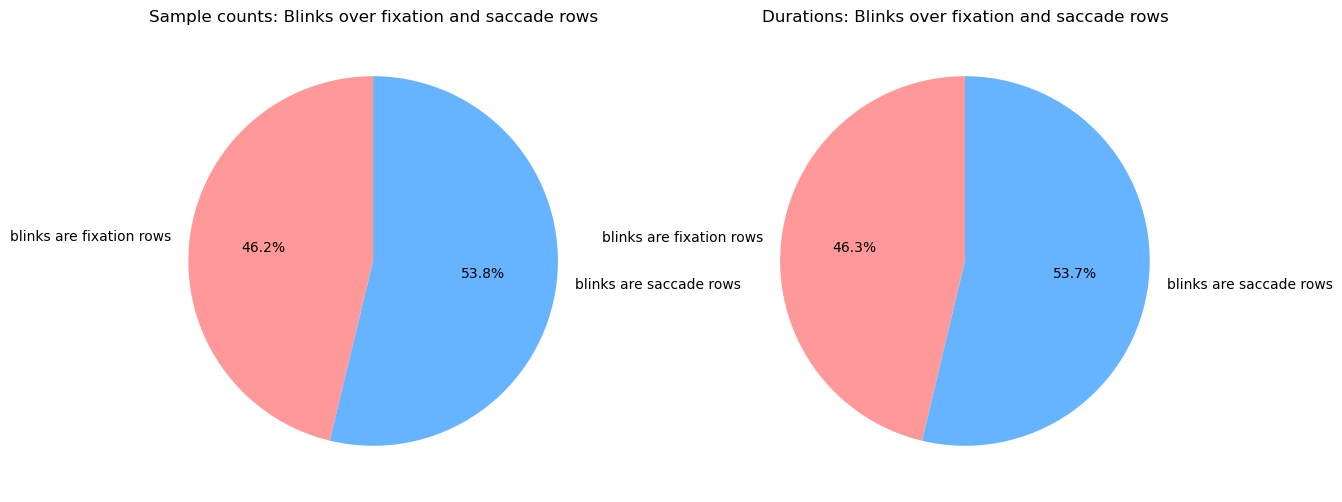

In [26]:

# Sums for the number of samples
lengths = [blink_sum_isFix_samples, blink_sum_notFix_samples]
# Sums for the durations
durations = [blink_sum_isFix_durs, blink_sum_notFix_durs]

labels = ['blinks are fixation rows', 'blinks are saccade rows']

plt.figure(figsize=(14, 6))

# Pie chart for sample counts
plt.subplot(1, 2, 1)
plt.pie(lengths, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff'])
plt.title('Sample counts: Blinks over fixation and saccade rows')

# Pie chart for durations
plt.subplot(1, 2, 2)
plt.pie(durations, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff'])
plt.title('Durations: Blinks over fixation and saccade rows')

# Save figure
full_save_path = os.path.join(savepath, 'pie_blinks.png')
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

plt.show()

6526936
1366883.9870000025


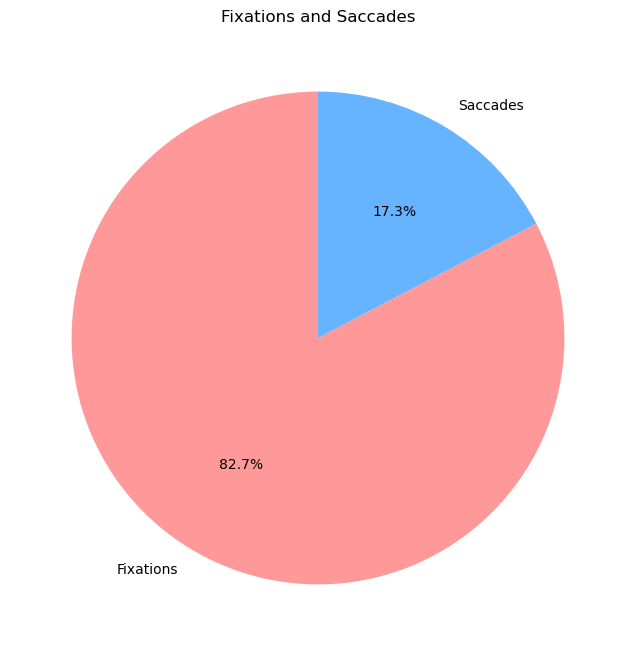

In [27]:
# Calculate the lengths
# gaze_sum = combined_gaze_data.sum()
# saccade_sum = combined_saccade_data.sum()
# noData_sum = combined_noData_data.sum()

gaze_sum = sum(fixationDurations)
saccade_sum = sum(saccadeDurations)


allD = gaze_sum + saccade_sum 
print(gaze_sum)
print(saccade_sum)

# Combine lengths into a list
lengths = [gaze_sum, saccade_sum]

# Define labels for the pie chart
labels = ['Fixations', 'Saccades']

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(lengths, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Fixations and Saccades')


# Combine the save path and filename
full_save_path = os.path.join(savepath, 'pie_fixation_saccade_sum.png')

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')


plt.show()

907629.298
907629.298


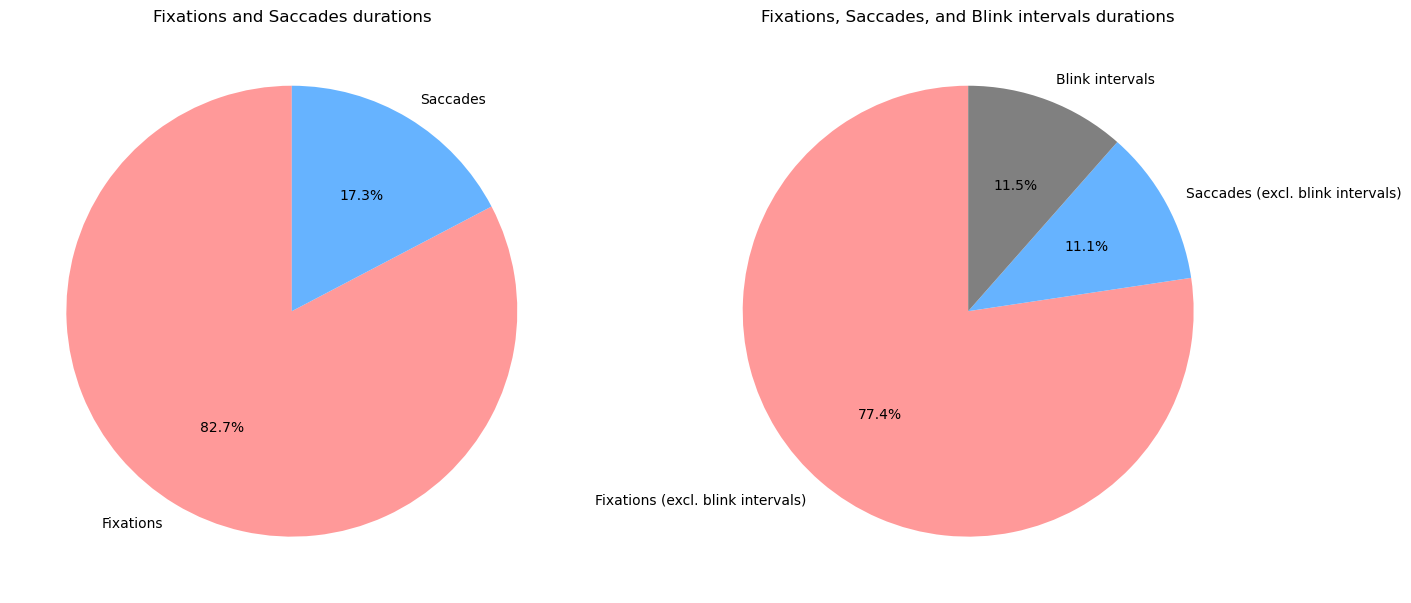

In [28]:
# Your existing sums (in ms)
gaze_sum = sum(fixationDurations)           # ms
saccade_sum = sum(saccadeDurations)         # ms

# Blink durations (convert from ns to ms)
blink_sum_isFix_durs_ms = blink_sum_isFix_durs / 1e6      # ms
blink_sum_notFix_durs_ms = blink_sum_notFix_durs / 1e6    # ms
blink_total_ms = blink_sum_isFix_durs_ms + blink_sum_notFix_durs_ms

print(blink_total_ms)
print(blink_sum_allDurs / 1e6 )

# Durations with blink intervals removed
fixations_wo_blinks = gaze_sum - blink_sum_isFix_durs_ms
saccades_wo_blinks = saccade_sum - blink_sum_notFix_durs_ms

# For the two plots:
pie1_lengths = [gaze_sum, saccade_sum]
pie1_labels = ['Fixations', 'Saccades']

pie2_lengths = [fixations_wo_blinks, saccades_wo_blinks, blink_total_ms]
pie2_labels = ['Fixations (excl. blink intervals)', 'Saccades (excl. blink intervals)', 'Blink intervals']

colors1 = ['#ff9999', '#66b3ff']
colors2 = ['#ff9999', '#66b3ff', 'grey']

plt.figure(figsize=(16, 8))

# First pie: only fixations and saccades
plt.subplot(1, 2, 1)
plt.pie(pie1_lengths, labels=pie1_labels, autopct='%1.1f%%', startangle=90, colors=colors1)
plt.title('Fixations and Saccades durations')

# Second pie: fixations, saccades, and blinks
plt.subplot(1, 2, 2)
plt.pie(pie2_lengths, labels=pie2_labels, autopct='%1.1f%%', startangle=90, colors=colors2)
plt.title('Fixations, Saccades, and Blink intervals durations')

# Save figure
full_save_path = os.path.join(savepath, 'pie_fixation_saccade_blink_sum.png')
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')
plt.show()

## eye movement duration distribution

In [29]:
# set figure style for all other figures
sns.set_style("whitegrid")


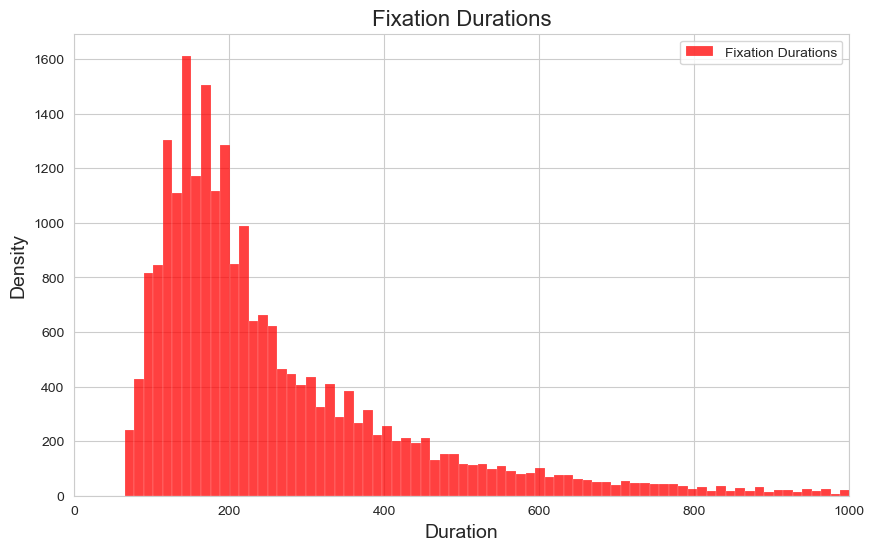

In [30]:
# binwidth = 1/90 

plt.figure(figsize=(10, 6))

# Plot KDE for gaze durations in blue
sns.histplot(fixationDurations, color='red', label='Fixation Durations')

# # Plot KDE for saccade durations in red
# sns.histplot(combined_saccade_data, kde=True, color='red', label='Saccade Durations', binwidth=binwidth)

# plt.axvline(x=0.2666, color='black', linestyle='--', linewidth=1, label='0.25 Threshold')


# Add labels and title
plt.xlabel('Duration', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Fixation Durations', fontsize=16)

plt.xlim(0, 1000)

# Show legend
plt.legend()


# Combine the save path and filename
full_save_path = os.path.join(savepath, 'fixation_durations.png')

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


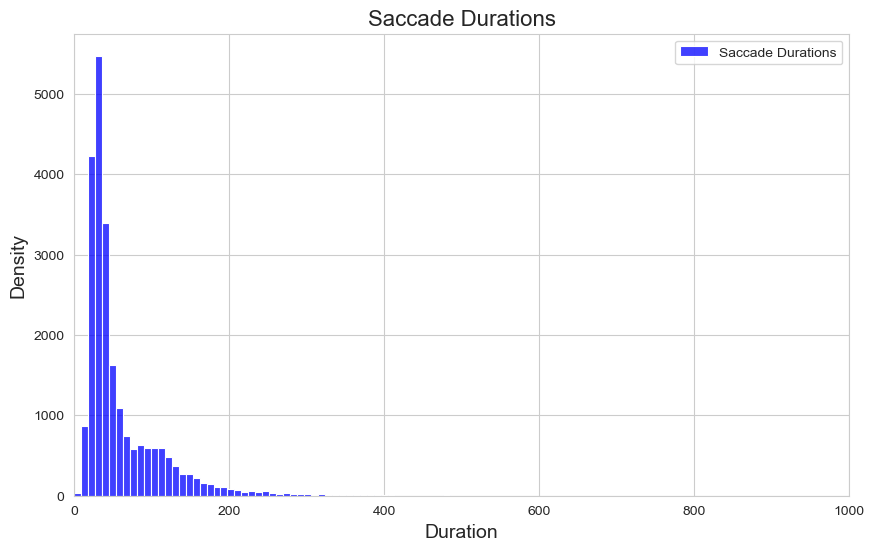

In [31]:
binwidth = 9

plt.figure(figsize=(10, 6))

# Plot KDE for gaze durations in blue
sns.histplot(saccadeDurations, color='blue', label='Saccade Durations', binwidth=binwidth)

# # Plot KDE for saccade durations in red
# sns.histplot(combined_saccade_data, kde=True, color='red', label='Saccade Durations', binwidth=binwidth)

# plt.axvline(x=0.2666, color='black', linestyle='--', linewidth=1, label='0.25 Threshold')


# Add labels and title
plt.xlabel('Duration', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Saccade Durations', fontsize=16)

plt.xlim(0, 1000)

# Show legend
plt.legend()


# Combine the save path and filename
full_save_path = os.path.join(savepath, 'Saccade_durations.png')

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [32]:
np.median(saccadeDurations)


39.924

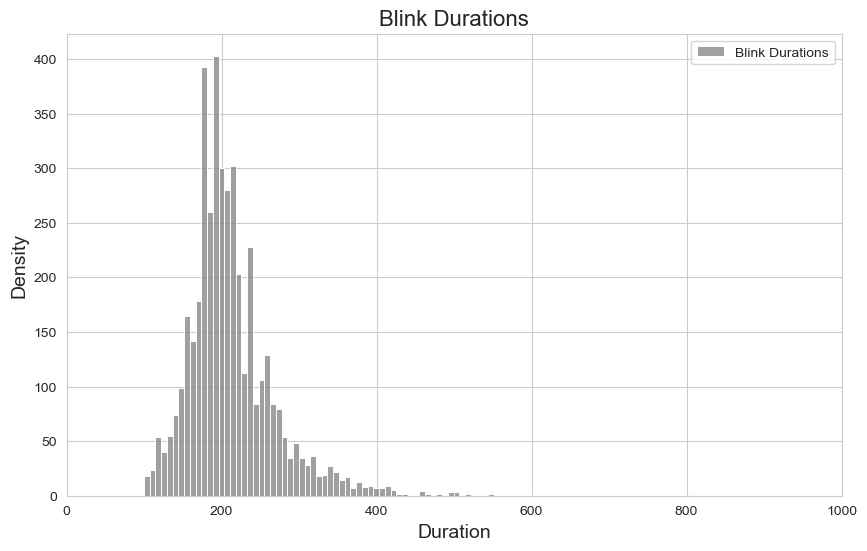

In [33]:
# binwidth = 1/90 

plt.figure(figsize=(10, 6))

# Plot KDE for gaze durations in blue
sns.histplot(blinkDurations, color='grey', label='Blink Durations')

# # Plot KDE for saccade durations in red
# sns.histplot(combined_saccade_data, kde=True, color='red', label='Saccade Durations', binwidth=binwidth)

# plt.axvline(x=0.2666, color='black', linestyle='--', linewidth=1, label='0.25 Threshold')


# Add labels and title
plt.xlabel('Duration', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Blink Durations', fontsize=16)

plt.xlim(0, 1000)

# Show legend
plt.legend()


# Combine the save path and filename
full_save_path = os.path.join(savepath, 'blink_durations.png')

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [34]:
# # binwidth = 1/90 

# plt.figure(figsize=(10, 6))

# sns.histplot(blinkDurations, color='grey', label='Blink Durations')

# # Plot KDE for gaze durations in blue
# sns.histplot(fixationDurations, color='blue', label='Fixation Durations')

# # # Plot KDE for saccade durations in red
# sns.histplot(saccadeDurations, color='red', label='Saccade Durations')

# # plt.axvline(x=0.2666, color='black', linestyle='--', linewidth=1, label='0.25 Threshold')


# # Add labels and title
# plt.xlabel('Duration', fontsize=14)
# plt.ylabel('Density', fontsize=14)
# plt.title('Fixation, Saccade, Blink Durations', fontsize=16)

# plt.xlim(0, 1000)




# # Show legend
# plt.legend()


# # Combine the save path and filename
# full_save_path = os.path.join(savepath, 'fixation_saccade_blink_durations.png')

# # Save the figure
# plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# # Show the plot
# plt.show()


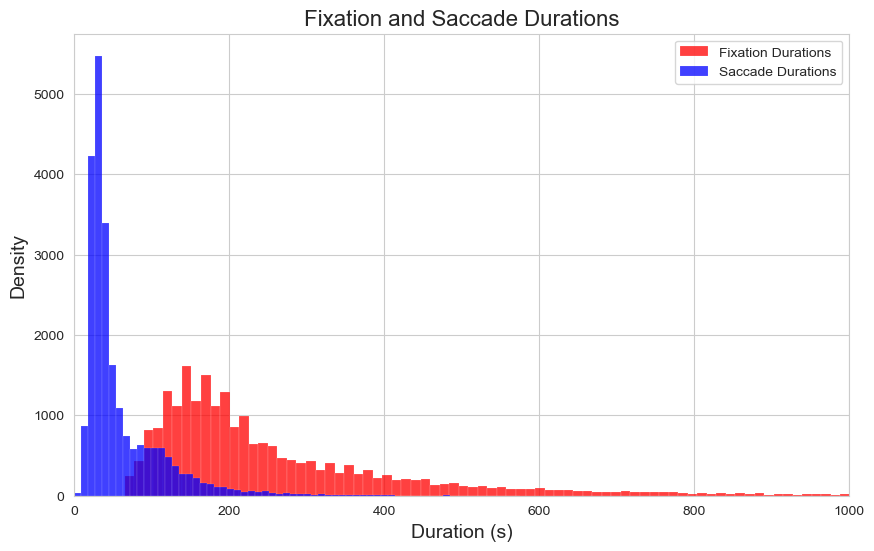

In [35]:
# binwidth = 1/90 

plt.figure(figsize=(10, 6))


# Plot KDE for gaze durations in blue
sns.histplot(fixationDurations, color='red', label='Fixation Durations')

# # Plot KDE for saccade durations in red
sns.histplot(saccadeDurations, color='blue', label='Saccade Durations',binwidth= 9)

# plt.axvline(x=0.2666, color='black', linestyle='--', linewidth=1, label='0.25 Threshold')


# Add labels and title
plt.xlabel('Duration (s)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Fixation and Saccade Durations', fontsize=16)

plt.xlim(0, 1000)
# Format x-axis to divide ticks by 1000 (e.g., ms → s)
# ax = plt.gca()
# ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1000:.2f}'))


# Show legend
plt.legend()


# Combine the save path and filename
full_save_path = os.path.join(savepath, 'fixation_saccade_durations.png')

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [36]:

big_df["duration_ms"] = big_df["duration_ns"]/ 1e6
big_df.head()

,event_id,first,last,duration_ns,duration_ms,event,session
0,1.0,1693904660577857803,1693904660600646803,22789000,22.789,saccade,Expl_1_ET_1_2023-09-05_11-56-16_ET
1,1060.0,1693904660610022803,1693904661400962803,790940000,790.940,fixation,Expl_1_ET_1_2023-09-05_11-56-16_ET
2,3.0,1693904661406934803,1693904661425591803,18657000,18.657,saccade,Expl_1_ET_1_2023-09-05_11-56-16_ET
3,1061.0,1693904661431881803,1693904661656971803,225090000,225.090,fixation,Expl_1_ET_1_2023-09-05_11-56-16_ET
4,5.0,1693904661659997803,1693904661685262803,25265000,25.265,saccade,Expl_1_ET_1_2023-09-05_11-56-16_ET


## plot saccades and fixations without blinks as in the best practices paper

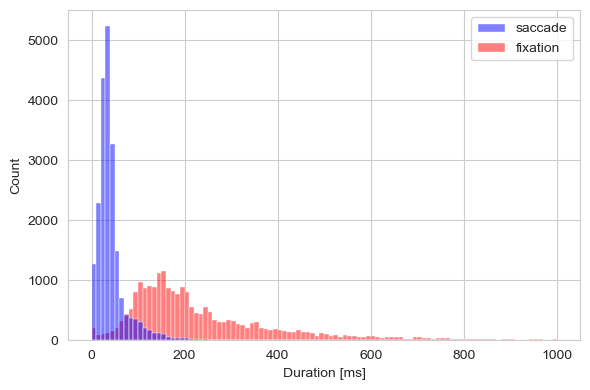

In [37]:
# Now let's plot the results:

filtered_df = big_df[big_df["duration_ms"] < 1000] # not not have such long events

# cmap= cm.roma
# pal = cmap(np.linspace(0, 1, 2)).tolist()
# plt.rcParams['font.family'] = 'TeX Gyre Heros'
pal = {'fixation': 'red', 'saccade': 'blue'}


fig, ax = plt.subplots(figsize=(6,4))
sns.set_style("whitegrid") 
sns.histplot(data=filtered_df, x="duration_ms", hue="event", bins=100, kde=False, palette=pal)
plt.xlabel("Duration [ms]")
plt.ylabel("Count")
ax.tick_params(axis='x')
ax.tick_params(axis='y')
legend = plt.gca().get_legend()  # get current axes legend
legend.set_title(None)  

plt.tight_layout()
plt.savefig("et_fix_sac_dur.png", bbox_inches="tight", pad_inches=0.3, dpi=400)
plt.show()

## plot both visualizations next to each other

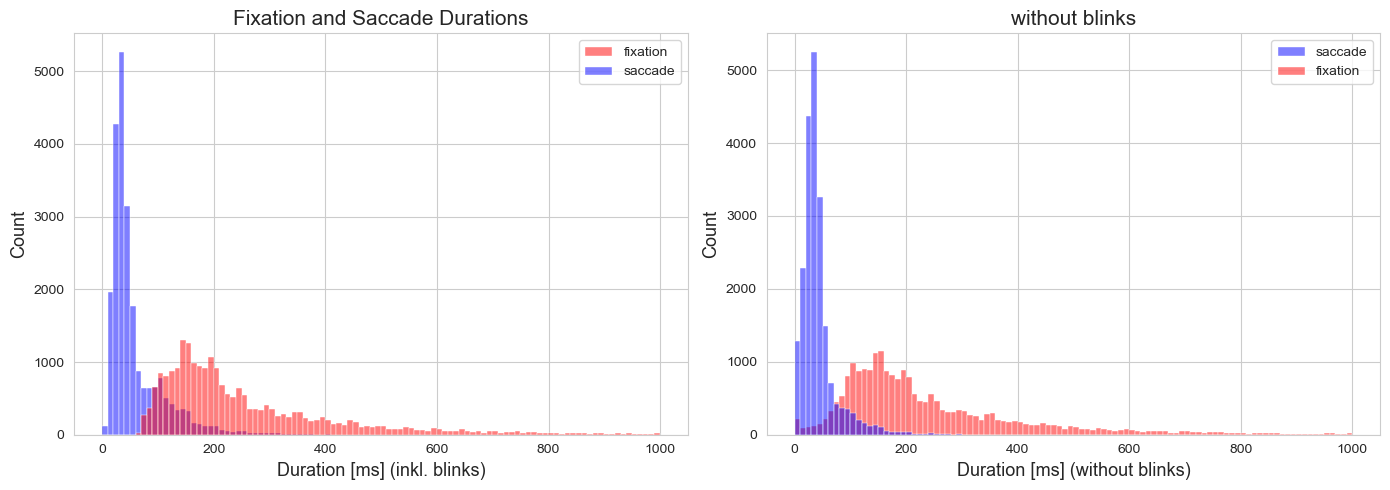

In [38]:
# filter the data sources to only plot everything below 1 sec of duration

filtered_df = big_df[big_df["duration_ms"] < 1000] 

# Make durations a DataFrame for consistent plotting
fix_df = pd.DataFrame({'duration_ms': fixationDurations, 'event': 'fixation'})
sac_df = pd.DataFrame({'duration_ms': saccadeDurations, 'event': 'saccade'})
comb_durs = pd.concat([fix_df, sac_df], ignore_index=True)

# Prefilter to match filtered_df's constraints (e.g., duration < 1000 ms)
comb_durs_filtered = comb_durs[comb_durs["duration_ms"] < 1000]



# cmap= cm.roma
# pal = cmap(np.linspace(0, 1, 2)).tolist()
# plt.rcParams['font.family'] = 'TeX Gyre Heros'
pal = {'fixation': 'red', 'saccade': 'blue'}



sns.set_style("whitegrid")

# Set up figure and axes
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# ---------- FIRST HISTPLOT ----------
palette = {'fixation': 'red', 'saccade': 'blue'}


# ---------- first plot - ignoring blinks ----------

sns.histplot(
    data=comb_durs_filtered ,
    x="duration_ms",
    hue="event",
    bins=100,
    kde=False,
    palette=palette,
    ax=axes[0]
)

axes[0].set_xlabel("Duration [ms] (inkl. blinks)", fontsize=13)
axes[0].set_ylabel("Count", fontsize=13)
axes[0].set_title("Fixation and Saccade Durations", fontsize=15)
axes[0].tick_params(axis='x')
axes[0].tick_params(axis='y')
if axes[0].get_legend() is not None:
    axes[0].get_legend().set_title(None)

# second plot - only consider events without blinks (best practices paper) 

sns.histplot(
    data=filtered_df,
    x="duration_ms",
    hue="event",
    bins=100,
    kde=False,
    palette=palette,
    ax=axes[1]
)

axes[1].set_xlabel("Duration [ms] (without blinks)", fontsize=13)
axes[1].set_ylabel("Count", fontsize=13)
axes[1].set_title("without blinks", fontsize=15)
axes[1].tick_params(axis='x')
axes[1].tick_params(axis='y')
if axes[1].get_legend() is not None:
    axes[1].get_legend().set_title(None)


plt.tight_layout()

# Save the figure (adjust path if needed)
full_save_path = os.path.join(savepath, 'durations_comparison_both.png')
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')
plt.show()

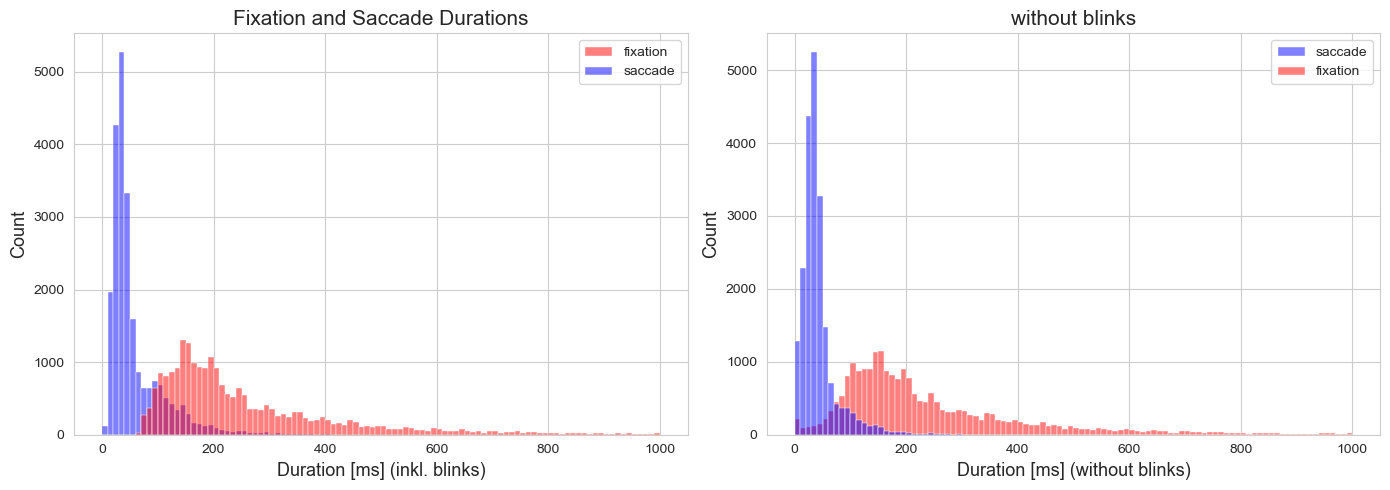

In [39]:
# filter the data sources to only plot everything below 1 sec of duration
bins = np.linspace(0, 1000, 101)  # 100 bins, 101 edges


filtered_df = big_df[big_df["duration_ms"] < 1000] 

# Make durations a DataFrame for consistent plotting
fix_df = pd.DataFrame({'duration_ms': fixationDurations, 'event': 'fixation'})
sac_df = pd.DataFrame({'duration_ms': saccadeDurations, 'event': 'saccade'})
comb_durs = pd.concat([fix_df, sac_df], ignore_index=True)

# Prefilter to match filtered_df's constraints (e.g., duration < 1000 ms)
comb_durs_filtered = comb_durs[comb_durs["duration_ms"] < 1000]



# cmap= cm.roma
# pal = cmap(np.linspace(0, 1, 2)).tolist()
# plt.rcParams['font.family'] = 'TeX Gyre Heros'
pal = {'fixation': 'red', 'saccade': 'blue'}



sns.set_style("whitegrid")

# Set up figure and axes
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# ---------- FIRST HISTPLOT ----------


# ---------- first plot - ignoring blinks ----------

sns.histplot(
    data=comb_durs_filtered ,
    x="duration_ms",
    hue="event",
    bins=bins,
    kde=False,
    palette=pal,
    ax=axes[0]
)

axes[0].set_xlabel("Duration [ms] (inkl. blinks)", fontsize=13)
axes[0].set_ylabel("Count", fontsize=13)
axes[0].set_title("Fixation and Saccade Durations", fontsize=15)
axes[0].tick_params(axis='x')
axes[0].tick_params(axis='y')
if axes[0].get_legend() is not None:
    axes[0].get_legend().set_title(None)

# second plot - only consider events without blinks (best practices paper) 

sns.histplot(
    data=filtered_df,
    x="duration_ms",
    hue="event",
    bins=bins,
    kde=False,
    palette=pal,
    ax=axes[1]
)

axes[1].set_xlabel("Duration [ms] (without blinks)", fontsize=13)
axes[1].set_ylabel("Count", fontsize=13)
axes[1].set_title("without blinks", fontsize=15)
axes[1].tick_params(axis='x')
axes[1].tick_params(axis='y')
if axes[1].get_legend() is not None:
    axes[1].get_legend().set_title(None)


plt.tight_layout()

# Save the figure (adjust path if needed)
full_save_path = os.path.join(savepath, 'durations_comparison_both_fixedBins.png')
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')
plt.show()

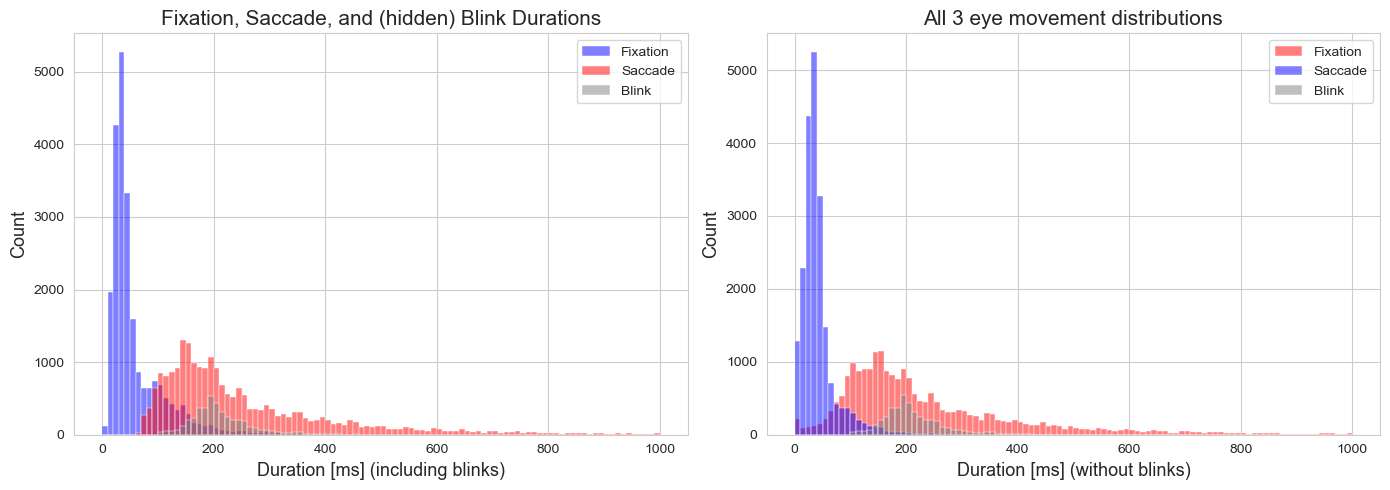

In [40]:
bins = np.linspace(0, 1000, 101)  # 100 bins, 101 edges

# Filter blink durations too
blinkDurations_filtered = [d for d in blinkDurations if d < 1000]

# Set up figure and axes
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

palette = {'fixation': 'red', 'saccade': 'blue'}

# ---------- FIRST SUBPLOT (INCLUDING BLINK DATA) ----------
sns.histplot(
    data=comb_durs_filtered,
    x="duration_ms",
    hue="event",
    bins=bins,
    kde=False,
    palette=palette,
    alpha=0.5,
    ax=axes[0],
    legend=False  # We'll do legends manually below
)
# Overlay blink histogram
sns.histplot(
    blinkDurations_filtered,
    color="grey",
    bins=bins,
    kde=False,
    alpha=0.5,
    ax=axes[0],
    label="Blink Durations"
)

axes[0].set_xlabel("Duration [ms] (including blinks)", fontsize=13)
axes[0].set_ylabel("Count", fontsize=13)
axes[0].set_title("Fixation, Saccade, and (hidden) Blink Durations", fontsize=15)
axes[0].tick_params(axis='x')
axes[0].tick_params(axis='y')
axes[0].legend(['Fixation', 'Saccade', 'Blink'])

# ---------- SECOND SUBPLOT (WITHOUT BLINK DATA) ----------
sns.histplot(
    data=filtered_df,
    x="duration_ms",
    hue="event",
    bins=bins,
    kde=False,
    palette=palette,
    alpha=0.5,
    ax=axes[1],
    legend=False
)
sns.histplot(
    blinkDurations_filtered,
    color="grey",
    bins=bins,
    kde=False,
    alpha=0.5,
    ax=axes[1],
    label="Blink Durations"
)

axes[1].set_xlabel("Duration [ms] (without blinks)", fontsize=13)
axes[1].set_ylabel("Count", fontsize=13)
axes[1].set_title("All 3 eye movement distributions", fontsize=15)
axes[1].tick_params(axis='x')
axes[1].tick_params(axis='y')
axes[1].legend(['Fixation', 'Saccade', 'Blink'])

plt.tight_layout()
full_save_path = os.path.join(savepath, 'durations_comparison_with_blinks.png')
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')
plt.show()


In [41]:
# # similar to other plot, but does not pre-assign the bins, so blinks look different
# # Filter blink durations too
# blinkDurations_filtered = [d for d in blinkDurations if d < 1000]

# # Set up figure and axes
# sns.set_style("whitegrid")
# fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# palette = {'fixation': 'red', 'saccade': 'blue'}

# # ---------- FIRST SUBPLOT (INCLUDING BLINK DATA) ----------
# sns.histplot(
#     data=comb_durs_filtered,
#     x="duration_ms",
#     hue="event",
#     bins=100,
#     kde=False,
#     palette=palette,
#     alpha=0.6,
#     ax=axes[0],
#     legend=False  # We'll do legends manually below
# )
# # Overlay blink histogram
# sns.histplot(
#     blinkDurations_filtered,
#     color="grey",
#     bins=100,
#     kde=False,
#     alpha=1,
#     ax=axes[0],
#     label="Blink Durations"
# )

# axes[0].set_xlabel("Duration [ms] (including blinks)", fontsize=13)
# axes[0].set_ylabel("Count", fontsize=13)
# axes[0].set_title("Fixation, Saccade, and Blink Durations", fontsize=15)
# axes[0].tick_params(axis='x')
# axes[0].tick_params(axis='y')
# axes[0].legend(['Fixation', 'Saccade', 'Blink'])

# # ---------- SECOND SUBPLOT (WITHOUT BLINK DATA) ----------
# sns.histplot(
#     data=filtered_df,
#     x="duration_ms",
#     hue="event",
#     bins=100,
#     kde=False,
#     palette=palette,
#     alpha=0.6,
#     ax=axes[1],
#     legend=False
# )
# sns.histplot(
#     blinkDurations_filtered,
#     color="grey",
#     bins=100,
#     kde=False,
#     alpha=1,
#     ax=axes[1],
#     label="Blink Durations"
# )

# axes[1].set_xlabel("Duration [ms] (without blinks)", fontsize=13)
# axes[1].set_ylabel("Count", fontsize=13)
# axes[1].set_title("without blinks + Blink Overlay", fontsize=15)
# axes[1].tick_params(axis='x')
# axes[1].tick_params(axis='y')
# axes[1].legend(['Fixation', 'Saccade', 'Blink'])

# plt.tight_layout()
# full_save_path = os.path.join(savepath, 'durations_comparison_with_blinks2.png')
# plt.savefig(full_save_path, dpi=300, bbox_inches='tight')
# plt.show()

In [42]:
# print('--------eye movement statistics----------')
# print('------------------------------------------')
# print('-------------fixation stats----------')
# print(min(fixationDurations))
# print(max(fixationDurations))
# print(np.mean(fixationDurations))
# print(np.median(fixationDurations))

# print('------------saccade stats----------')
# print(min(saccadeDurations))
# print(max(saccadeDurations))
# print(np.mean(saccadeDurations))
# print(np.median(saccadeDurations))

# print('-------------blink stats----------')
# print(min(blinkDurations))
# print(max(blinkDurations))
# print(np.mean(blinkDurations))
# print(np.median(blinkDurations))
print('-------- eye movement statistics ----------')
print('------------------------------------------')

print('------------- Fixation stats ----------')
print("Min:", min(fixationDurations))
print("Max:", max(fixationDurations))
print("Max (s):", max(fixationDurations)/1000)
print("Mean:", np.mean(fixationDurations))
print("Median:", np.median(fixationDurations))

print('------------ Saccade stats ----------')
print("Min:", min(saccadeDurations))
print("Max:", max(saccadeDurations))
print("Mean:", np.mean(saccadeDurations))
print("Median:", np.median(saccadeDurations))

print('------------- Blink stats ----------')
print("Min:", min(blinkDurations))
print("Max:", max(blinkDurations))
print("Mean:", np.mean(blinkDurations))
print("Median:", np.median(blinkDurations))

-------- eye movement statistics ----------
------------------------------------------
------------- Fixation stats ----------
Min: 65
Max: 5496
Max (s): 5.496
Mean: 281.33344827586205
Median: 205.0
------------ Saccade stats ----------
Min: 0.0
Max: 574.94
Mean: 58.88441765390084
Median: 39.924
------------- Blink stats ----------
Min: 100
Max: 640
Mean: 212.40178571428572
Median: 200.0


In [43]:
# Stats for FIXATIONS
fix_durs = big_df.loc[big_df['event'] == 'fixation', 'duration_ms']

print("Fixations:")
print("Min:", fix_durs.min())
print("Max:", fix_durs.max())
print("Max (s):", fix_durs.max()/1000)

print("Mean:", fix_durs.mean())
print("Median:", fix_durs.median())

# Stats for SACCADES (if desired)
sac_durs = big_df.loc[big_df['event'] == 'saccade', 'duration_ms']

print("\nSaccades:")
print("Min:", sac_durs.min())
print("Max:", sac_durs.max())
print("Mean:", sac_durs.mean())
print("Median:", sac_durs.median())

Fixations:
Min: 0.0
Max: 5490.75
Max (s): 5.49075
Mean: 262.9972078813856
Median: 190.538

Saccades:
Min: 0.0
Max: 481.375
Mean: 42.15806466129797
Median: 34.323


In [44]:
# test the uncut fixations

print('------------- Fixation stats ----------')
print("Min:", min(allFixationDurationsUnsliced))
print("Max:", max(allFixationDurationsUnsliced))
print("Max (s):", max(allFixationDurationsUnsliced)/1000)
print("Mean:", np.mean(allFixationDurationsUnsliced))
print("Median:", np.median(allFixationDurationsUnsliced))

------------- Fixation stats ----------
Min: 65
Max: 5496
Max (s): 5.496
Mean: 281.33344827586205
Median: 205.0
